# 0. Imports

Import τα απατούμενα packages της Python

In [297]:
import pandas as pd

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps

import torch
from torch import nn
# from torchmetrics.classification import BinaryAccuracy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

# 1. Προετοιμασία δεδομένων

### 1.1 Φόρτωση των δεδομένων

In [298]:
df = pd.read_excel('movies.xlsx')
pd.set_option('display.max_columns', None)

# Truncate
pd.set_option('display.max_rows', None) # Change False to None to not truncate

### 1.2 Γενική εικόνα των δεδομένων

In [299]:
df.head()

,Film,Year,Script Type,Rotten Tomatoes critics,Metacritic critics,Average critics,Rotten Tomatoes Audience,Metacritic Audience,Rotten Tomatoes vs Metacritic deviance,Average audience,Audience vs Critics deviance,Primary Genre,Genre,Opening Weekend,Opening weekend ($million),Domestic Gross,Domestic gross ($million),Foreign Gross ($million),Foreign Gross,Worldwide Gross,Worldwide Gross ($million),of Gross earned abroad,Budget ($million),Budget recovered,Budget recovered opening weekend,Distributor,IMDb Rating,IMDB vs RT disparity,Release Date (US),Oscar Winners,Oscar Detail
0,300,2007,adaptation,60,51,56,89.0,71,18,80,-25,action,"period, action",70885301,70.89,210614939,210.61,245.45,245453242,456068181,456.0,53.82%,65,701.64%,109.05%,NaN,NaN,NaN,"Mar 9, 2007",NaN,NaN
1,3:10 to Yuma,2007,remake,88,76,82,86.0,73,13,80,3,western,western,14035033,14.04,53606916,53.61,16.17,16173815,69780731,70.0,23.18%,50,139.56%,28.07%,NaN,NaN,NaN,"Sep 7, 2007",NaN,NaN
2,30 Days of Night,2007,adaptation,50,53,52,56.0,65,-9,61,-9,horror,horror,15951902,15.95,39568996,39.57,35.53,35526091,75095087,75.0,47.31%,32,234.67%,49.85%,NaN,NaN,NaN,"Oct 19, 2007",NaN,NaN
3,Across the Universe,2007,original screenplay,54,56,55,82.0,73,9,78,-23,musical,musical,3824988,3.82,24343673,24.34,5.02,5023470,29367143,29.0,17.11%,45,65.26%,8.50%,NaN,NaN,NaN,"Oct 12, 2007",NaN,NaN
4,Alien vs. Predator - Requiem,2007,sequel,14,29,22,31.0,45,-14,38,-17,sci-fi,"sci-fi, horror",10059425,10.06,41797066,41.80,87.09,87086650,128883716,129.0,67.57%,40,322.21%,25.15%,NaN,NaN,NaN,"Dec 25, 2007",NaN,NaN


In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Film                                     1402 non-null   object 
 1   Year                                     1402 non-null   int64  
 2   Script Type                              1402 non-null   object 
 3   Rotten Tomatoes  critics                 1401 non-null   object 
 4   Metacritic  critics                      1402 non-null   object 
 5   Average critics                          1402 non-null   object 
 6   Rotten Tomatoes Audience                 1401 non-null   float64
 7   Metacritic Audience                      1402 non-null   object 
 8   Rotten Tomatoes vs Metacritic  deviance  1402 non-null   object 
 9   Average audience                         1402 non-null   object 
 10  Audience vs Critics deviance             1402 no

In [301]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1402.0,2012.140514,3.190291,2007.0,2009.0000,2012.000,2015.0000,2017.00
Rotten Tomatoes Audience,1401.0,62.122769,17.435737,17.0,49.0000,62.000,76.0000,98.00
Opening weekend ($million),1402.0,23.200357,28.547541,0.0,6.6025,14.200,28.5975,247.97
Domestic gross ($million),1402.0,74.058024,87.389737,0.0,21.0900,44.045,92.5900,936.66
Worldwide Gross ($million),1402.0,173.008302,233.859025,0.0,38.0000,88.690,208.7500,2781.50
Distributor,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMDb Rating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMDB vs RT disparity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [302]:
df.describe(include='object').T

,count,unique,top,freq
Film,1402,1396,Big Miracle,2
Script Type,1402,17,original screenplay,546
Rotten Tomatoes critics,1401,102,93,29
Metacritic critics,1402,90,51,39
Average critics,1402,196,64,25
Metacritic Audience,1402,78,66,50
Rotten Tomatoes vs Metacritic deviance,1402,82,-1,58
Average audience,1402,116,58,45
Audience vs Critics deviance,1402,78,-5,54
Primary Genre,19,11,comedy,5


# 2. Data cleanup

## 2.1 Έλεγχος για διπλότυπα

Το μόνο που μας ενδιαφέρει είναι το όνομα της ταινίας

In [303]:
df[df.duplicated(subset=['Film'], keep=False)]

,Film,Year,Script Type,Rotten Tomatoes critics,Metacritic critics,Average critics,Rotten Tomatoes Audience,Metacritic Audience,Rotten Tomatoes vs Metacritic deviance,Average audience,Audience vs Critics deviance,Primary Genre,Genre,Opening Weekend,Opening weekend ($million),Domestic Gross,Domestic gross ($million),Foreign Gross ($million),Foreign Gross,Worldwide Gross,Worldwide Gross ($million),of Gross earned abroad,Budget ($million),Budget recovered,Budget recovered opening weekend,Distributor,IMDb Rating,IMDB vs RT disparity,Release Date (US),Oscar Winners,Oscar Detail
681,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.45,36931089,36.93,20.79,20788004,57719093,58.00,36.02%,70,82.46%,19.22%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
682,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.00,36931089,37.00,20.79,20788004,57719093,58.00,36.02%,70,82.46,18.57%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
703,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,7.76,20157300,20.16,4.56,4561915,24719215,25.00,18.45%,40,61.80%,19.40%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
704,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,8.00,20157300,20.00,4.56,4561915,24719215,25.00,18.45%,40,61.8,20.00%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
709,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.00,20275446,20.00,10.81,10808153,31083599,31.00,34.77%,35,88.81,17.14%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
710,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.03,20275446,20.28,10.81,10808153,31083599,31.00,34.77%,35,88.81%,17.23%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
713,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,0.74,16377274,16.38,11.88,11880786,28258060,28.00,42.04%,32,88.31%,2.30%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
714,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,1.00,16377274,16.00,11.88,11880786,28258060,28.00,42.04%,32,88.31,3.13%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
1001,The Good Dinosaur,2015,original screenplay,77,66,72,66.0,70,-4,68,4,NaN,Adventure,39155217,39.00,123087120,123.09,209.12,209120551,332207671,332.21,62.95%,200,166%,19.58%,NaN,NaN,NaN,"Nov 25, 2015",NaN,NaN
1062,The Big Short,2015,adaptation,87,81,84,89.0,89,0,89,-5,NaN,drama,10531026,10.53,60900477,60.90,41.80,41800000,102700477,103.00,40.70%,28,366.79%,37.61%,NaN,NaN,NaN,"December 11, 2015",NaN,NaN


Διαγραφή διπλότυπων

In [304]:
df = df.drop_duplicates(subset=['Film'])

## 2.2 Handle missing values

In [305]:
missing_data = df.isnull().sum()
print(missing_data)

Film                                          0
Year                                          0
Script Type                                   0
Rotten Tomatoes  critics                      1
Metacritic  critics                           0
Average critics                               0
Rotten Tomatoes Audience                      1
Metacritic Audience                           0
Rotten Tomatoes vs Metacritic  deviance       0
Average audience                              0
Audience vs Critics deviance                  0
Primary Genre                              1377
Genre                                         1
Opening Weekend                               0
Opening weekend ($million)                    0
Domestic Gross                                0
Domestic gross ($million)                     0
Foreign Gross ($million)                      0
Foreign Gross                                 0
Worldwide Gross                               0
Worldwide Gross ($million)              

In [306]:
# Print lines with missing values
df[df['Rotten Tomatoes  critics'].isnull() | df['Rotten Tomatoes Audience '].isnull() | df['Genre'].isnull() | df.isin(['-']).any(axis=1)]

,Film,Year,Script Type,Rotten Tomatoes critics,Metacritic critics,Average critics,Rotten Tomatoes Audience,Metacritic Audience,Rotten Tomatoes vs Metacritic deviance,Average audience,Audience vs Critics deviance,Primary Genre,Genre,Opening Weekend,Opening weekend ($million),Domestic Gross,Domestic gross ($million),Foreign Gross ($million),Foreign Gross,Worldwide Gross,Worldwide Gross ($million),of Gross earned abroad,Budget ($million),Budget recovered,Budget recovered opening weekend,Distributor,IMDb Rating,IMDB vs RT disparity,Release Date (US),Oscar Winners,Oscar Detail
504,Paranormal Activity 2,2010,sequel,NaN,53,53,NaN,58,-58,58,-5,NaN,horror,40670000,40.67,84750000,84.75,92.76,92760000,"177,510,000",177.51,52.26%,3,5917.00%,1355.67%,NaN,NaN,NaN,"Oct 22, 2010",NaN,NaN
930,Deliver Us From Evil,2014,adaptation,28,40,34,42.0,59,-17,51,-17,NaN,NaN,9740471,9.74,30477122,30.48,57.36,57360693,87937815,88.00,65.23%,30,293.13%,32.47%,NaN,NaN,NaN,"Jul 2, 2014",NaN,NaN
1268,Baahubali 2: The Conclusion,2017,sequel,100,-,-,87.0,85,2,86,-,NaN,"action, adventure",10430497,10.43,20186659,20.19,121.32,121319777,141506436,141.51,85.73%,39,362.84%,26.74%,NaN,NaN,NaN,"Apr 28, 2017",NaN,NaN
1272,Beatriz At Dinner,2017,original screenplay,75,68,72,56.0,52,4,54,18,NaN,comedy,141959,0.14,7115854,7.12,0.00,0,7115854,7.12,0.00%,-,-,-,NaN,NaN,NaN,"Jun 9, 2017",NaN,NaN
1317,Let there be Light,2017,original screenplay,60,-,-,78.0,55,23,67,-,NaN,drama,1729535,1.73,7184198,7.18,0.00,0,7184198,7.18,0.00%,3,239.47%,57.65%,NaN,NaN,NaN,"Nov 10, 2017",NaN,NaN
1322,Lowriders,2017,original screenplay,55,57,56,63.0,-,-,-,-,NaN,drama,2403885,2.40,6179955,6.18,0.00,0,6179955,6.18,0.00%,1,686.66%,267.10%,NaN,NaN,NaN,"May 12, 2017",NaN,NaN
1325,Megan Leavey,2017,based on a true story,84,66,75,83.0,65,18,74,1,NaN,drama,3810867,3.81,13406883,13.41,0.00,0,13406883,13.41,0.00%,-,-,-,NaN,NaN,NaN,"Jun 9, 2017",NaN,NaN
1367,The Glass Castle,2017,"adaptation, based on a true story",49,56,53,74.0,63,11,69,-16,NaN,drama,4678548,4.68,17273059,17.27,4.50,4497986,21771045,21.77,20.66%,-,-,-,NaN,NaN,NaN,"Aug 11, 2017",NaN,NaN
1375,The Man Who Invented Christmas,2017,"adaptation, based on a true story",80,60,70,84.0,61,23,73,-3,NaN,drama,1353297,1.35,4664004,4.66,0.00,0,4664004,4.66,0.00%,-,-,-,NaN,NaN,NaN,"Nov 22, 2017",NaN,NaN
1388,Til Death Do Us Part,2017,original screenplay,-,-,-,64.0,-,-,-,-,NaN,thriller,1527289,1.53,3455267,3.46,0.00,0,3455267,3.46,0.00%,-,-,-,NaN,NaN,NaN,"Sep 29, 2017",NaN,NaN


In [307]:
# Drop lines that contain null or invalid values
df = df.dropna(subset=['Genre', 'Rotten Tomatoes  critics', 'Rotten Tomatoes Audience '])
df = df[~df.isin(['-']).any(axis=1)]

## 2.4 Outlier detection

In [308]:
#Remove decimal points and percent symbols from numerical strings
df[['Rotten Tomatoes  critics', 'Metacritic  critics', 'Average critics ', 'Rotten Tomatoes Audience ', 'Metacritic Audience ', 'Rotten Tomatoes vs Metacritic  deviance',
    'Average audience ', 'Audience vs Critics deviance ', 'Opening Weekend', 'Opening weekend ($million)', 'Domestic Gross', 'Domestic gross ($million)', 'Foreign Gross ($million)',
    'Foreign Gross', 'Worldwide Gross', 'Worldwide Gross ($million)', ' of Gross earned abroad', 'Budget ($million)', ' Budget recovered', ' Budget recovered opening weekend', 'IMDb Rating','IMDB vs RT disparity']] = df[[
                'Rotten Tomatoes  critics', 'Metacritic  critics', 'Average critics ', 'Rotten Tomatoes Audience ', 'Metacritic Audience ', 'Rotten Tomatoes vs Metacritic  deviance',
                'Average audience ', 'Audience vs Critics deviance ', 'Opening Weekend', 'Opening weekend ($million)', 'Domestic Gross', 'Domestic gross ($million)', 'Foreign Gross ($million)',
                'Foreign Gross', 'Worldwide Gross', 'Worldwide Gross ($million)', ' of Gross earned abroad', 'Budget ($million)', ' Budget recovered', ' Budget recovered opening weekend', 'IMDb Rating','IMDB vs RT disparity']].replace(',','', regex=True)

df = df.replace('%','', regex=True)

In [309]:
# Convert strings to numerical values
df[['Rotten Tomatoes  critics',
 'Metacritic  critics',
 'Average critics ',
 'Rotten Tomatoes Audience ',
 'Metacritic Audience ',
 'Rotten Tomatoes vs Metacritic  deviance',
 'Average audience ',
 'Audience vs Critics deviance ',
 'Opening Weekend',
 'Opening weekend ($million)',
 'Domestic Gross',
 'Domestic gross ($million)',
 'Foreign Gross ($million)',
 'Foreign Gross',
 'Worldwide Gross',
 'Worldwide Gross ($million)',
 ' of Gross earned abroad',
 'Budget ($million)',
 ' Budget recovered',
 ' Budget recovered opening weekend',
 'IMDb Rating',
 'IMDB vs RT disparity']] = df[['Rotten Tomatoes  critics',
                                'Metacritic  critics',
                                'Average critics ',
                                'Rotten Tomatoes Audience ',
                                'Metacritic Audience ',
                                'Rotten Tomatoes vs Metacritic  deviance',
                                'Average audience ',
                                'Audience vs Critics deviance ',
                                'Opening Weekend',
                                'Opening weekend ($million)',
                                'Domestic Gross',
                                'Domestic gross ($million)',
                                'Foreign Gross ($million)',
                                'Foreign Gross',
                                'Worldwide Gross',
                                'Worldwide Gross ($million)',
                                ' of Gross earned abroad',
                                'Budget ($million)',
                                ' Budget recovered',
                                ' Budget recovered opening weekend',
                                'IMDb Rating',
                                'IMDB vs RT disparity']].apply(pd.to_numeric)

# Convert Oscar Winners to 1 hot encoding
df['Oscar Winners'] = df["Oscar Winners"].notnull().astype("int")

In [310]:
# Detect critic values outside normal range
df[(df['Rotten Tomatoes Audience '] < 0) | (df['Rotten Tomatoes Audience '] > 100) | (df['Rotten Tomatoes  critics'] < 0) | (df['Rotten Tomatoes  critics'] > 100)
   | (df['Metacritic  critics'] < 0 ) | (df['Metacritic  critics'] > 100) |  (df['Metacritic Audience '] < 0 ) | (df['Metacritic Audience ']) > 100].sum()

Film                                         0
Year                                         0
Script Type                                  0
Rotten Tomatoes  critics                     0
Metacritic  critics                          0
Average critics                            0.0
Rotten Tomatoes Audience                   0.0
Metacritic Audience                          0
Rotten Tomatoes vs Metacritic  deviance      0
Average audience                           0.0
Audience vs Critics deviance                 0
Primary Genre                                0
Genre                                        0
Opening Weekend                              0
Opening weekend ($million)                 0.0
Domestic Gross                               0
Domestic gross ($million)                  0.0
Foreign Gross ($million)                   0.0
Foreign Gross                              0.0
Worldwide Gross                              0
Worldwide Gross ($million)                 0.0
 of Gross ear

In [311]:
# Conver ' of Gross earned abroad' values to 0-1 range since '%' is removed
df[' of Gross earned abroad'] = df[' of Gross earned abroad'].apply(lambda s: s / 100)

### Cleaned dataset properties

In [312]:
df = df.reset_index()
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
index,1385.00,695.68,403.60,0.00,346.00,694.00,1044.00,1400.00
Year,1385.00,2012.10,3.18,2007.00,2009.00,2012.00,2015.00,2017.00
Rotten Tomatoes critics,1385.00,53.09,27.53,0.00,28.00,53.00,78.00,100.00
Metacritic critics,1385.00,53.63,17.43,9.00,41.00,53.00,66.00,100.00
Average critics,1385.00,53.59,22.17,6.00,35.00,53.00,72.00,99.00
Rotten Tomatoes Audience,1385.00,62.04,17.45,17.00,49.00,62.00,76.00,98.00
Metacritic Audience,1385.00,62.86,13.49,9.00,54.00,64.00,73.00,92.00
Rotten Tomatoes vs Metacritic deviance,1385.00,-0.71,12.52,-60.00,-9.00,0.00,7.00,84.00
Average audience,1385.00,62.62,14.42,7.00,52.00,63.00,73.00,93.00
Audience vs Critics deviance,1385.00,-9.22,13.91,-48.00,-20.00,-8.00,1.00,33.00


# 3. Feature exploration

### 3.1 Dataset preprocessing

### Convert `script type` and `genre` to 1 hot encoding

In [313]:
# Make a copy of dataframe
df_cl = df

In [314]:
from sklearn.preprocessing import OneHotEncoder



In [315]:
# Convert strings to lowercase
df_cl['Script Type'] = df_cl['Script Type'].str.lower()

# Extract all unique script type names
script_types = df_cl['Script Type'].unique()

# Split strings and remove trailing spaces
types = []
for string in script_types:
    types.append(re.split(' / |, ',string))
script_types = [j.strip() for sub in types for j in sub]

#Convert to set to remove dublicates
unique_script_types = set(script_types)

# Insert columns for each coresponding script type
for i, item in enumerate(unique_script_types):
    # df.insert(i+1, 'st_'+item, 0)
    # df.insert(-1, 'st_'+item, 0)
    df_cl.insert(i, 'st_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for script in unique_script_types:
        if script in df_cl.at[i, 'Script Type']:
            df_cl.at[i, 'st_'+script] = 1

# Drop script type and primary genre columns from dataframe
df_cl = df_cl.drop(['Script Type'], axis=1)

In [316]:
# TODO: Use spellchecking to remove invalid genres

# Convert genres to lower to avoid possible dublication
df_cl['Genre'] = df_cl['Genre'].str.lower()
genres = df_cl['Genre'].unique()

# Split strings and remove trailing spaces
unique_genres = []
for string in genres:
    unique_genres.append(re.split(', |. ',string))
genre_types = [j.strip() for sub in unique_genres for j in sub]

#Convert to set to remove dublicates
genre_types = set(genre_types)

# Remove invalid values
genre_types.remove('')
genre_types.remove('adventur')
genre_types.remove('biograph')
genre_types.remove('comed')
genre_types.remove('crim')
genre_types.remove('documentar')
genre_types.remove('dram')
genre_types.remove('famiily')
genre_types.remove('famil')
genre_types.remove('fantas')
genre_types.remove('horro')
genre_types.remove('musi')
genre_types.remove('music')
genre_types.remove('myster')
genre_types.remove('romanti')
genre_types.remove('sci-f')
genre_types.remove('sport')
genre_types.remove('thriler')
genre_types.remove('thrille')

# Insert columns for each coresponding script type
for i, item in enumerate(genre_types):
    # df.insert(i+9, 'gen_'+item, 0)
    df_cl.insert(i, 'gen_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for genre in genre_types:
        if genre in df_cl.at[i, 'Genre']:
            df_cl.at[i, 'gen_'+genre] = 1

# Drop original genre column
df_cl = df_cl.drop(['Genre'], axis=1)

In [317]:
# Drop unecessary primary genre
df_cl = df_cl.drop(['Primary Genre'], axis=1)

### Dataset overview 

In [318]:
# TODO: fix st_documentary position
df_cl.head().T

,0,1,2,3,4
gen_period,1,0,0,0,0
gen_biography,0,0,0,0,0
gen_war,0,0,0,0,0
gen_sports,0,0,0,0,0
gen_comedy,0,0,0,0,0
gen_fantasy,0,0,0,0,0
gen_history,0,0,0,0,0
gen_mystery,0,0,0,0,0
gen_sci-fi,0,0,0,0,1
gen_thriller,0,0,0,0,0


### 3.2 Corelation matrix

In [319]:
# remove non relevant columns
df_movie_names = df_cl[['Film', 'Oscar Winners']]
df_cl_corr = df_cl.drop(['Film', 'Year','Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)','Oscar Detail'], axis=1)

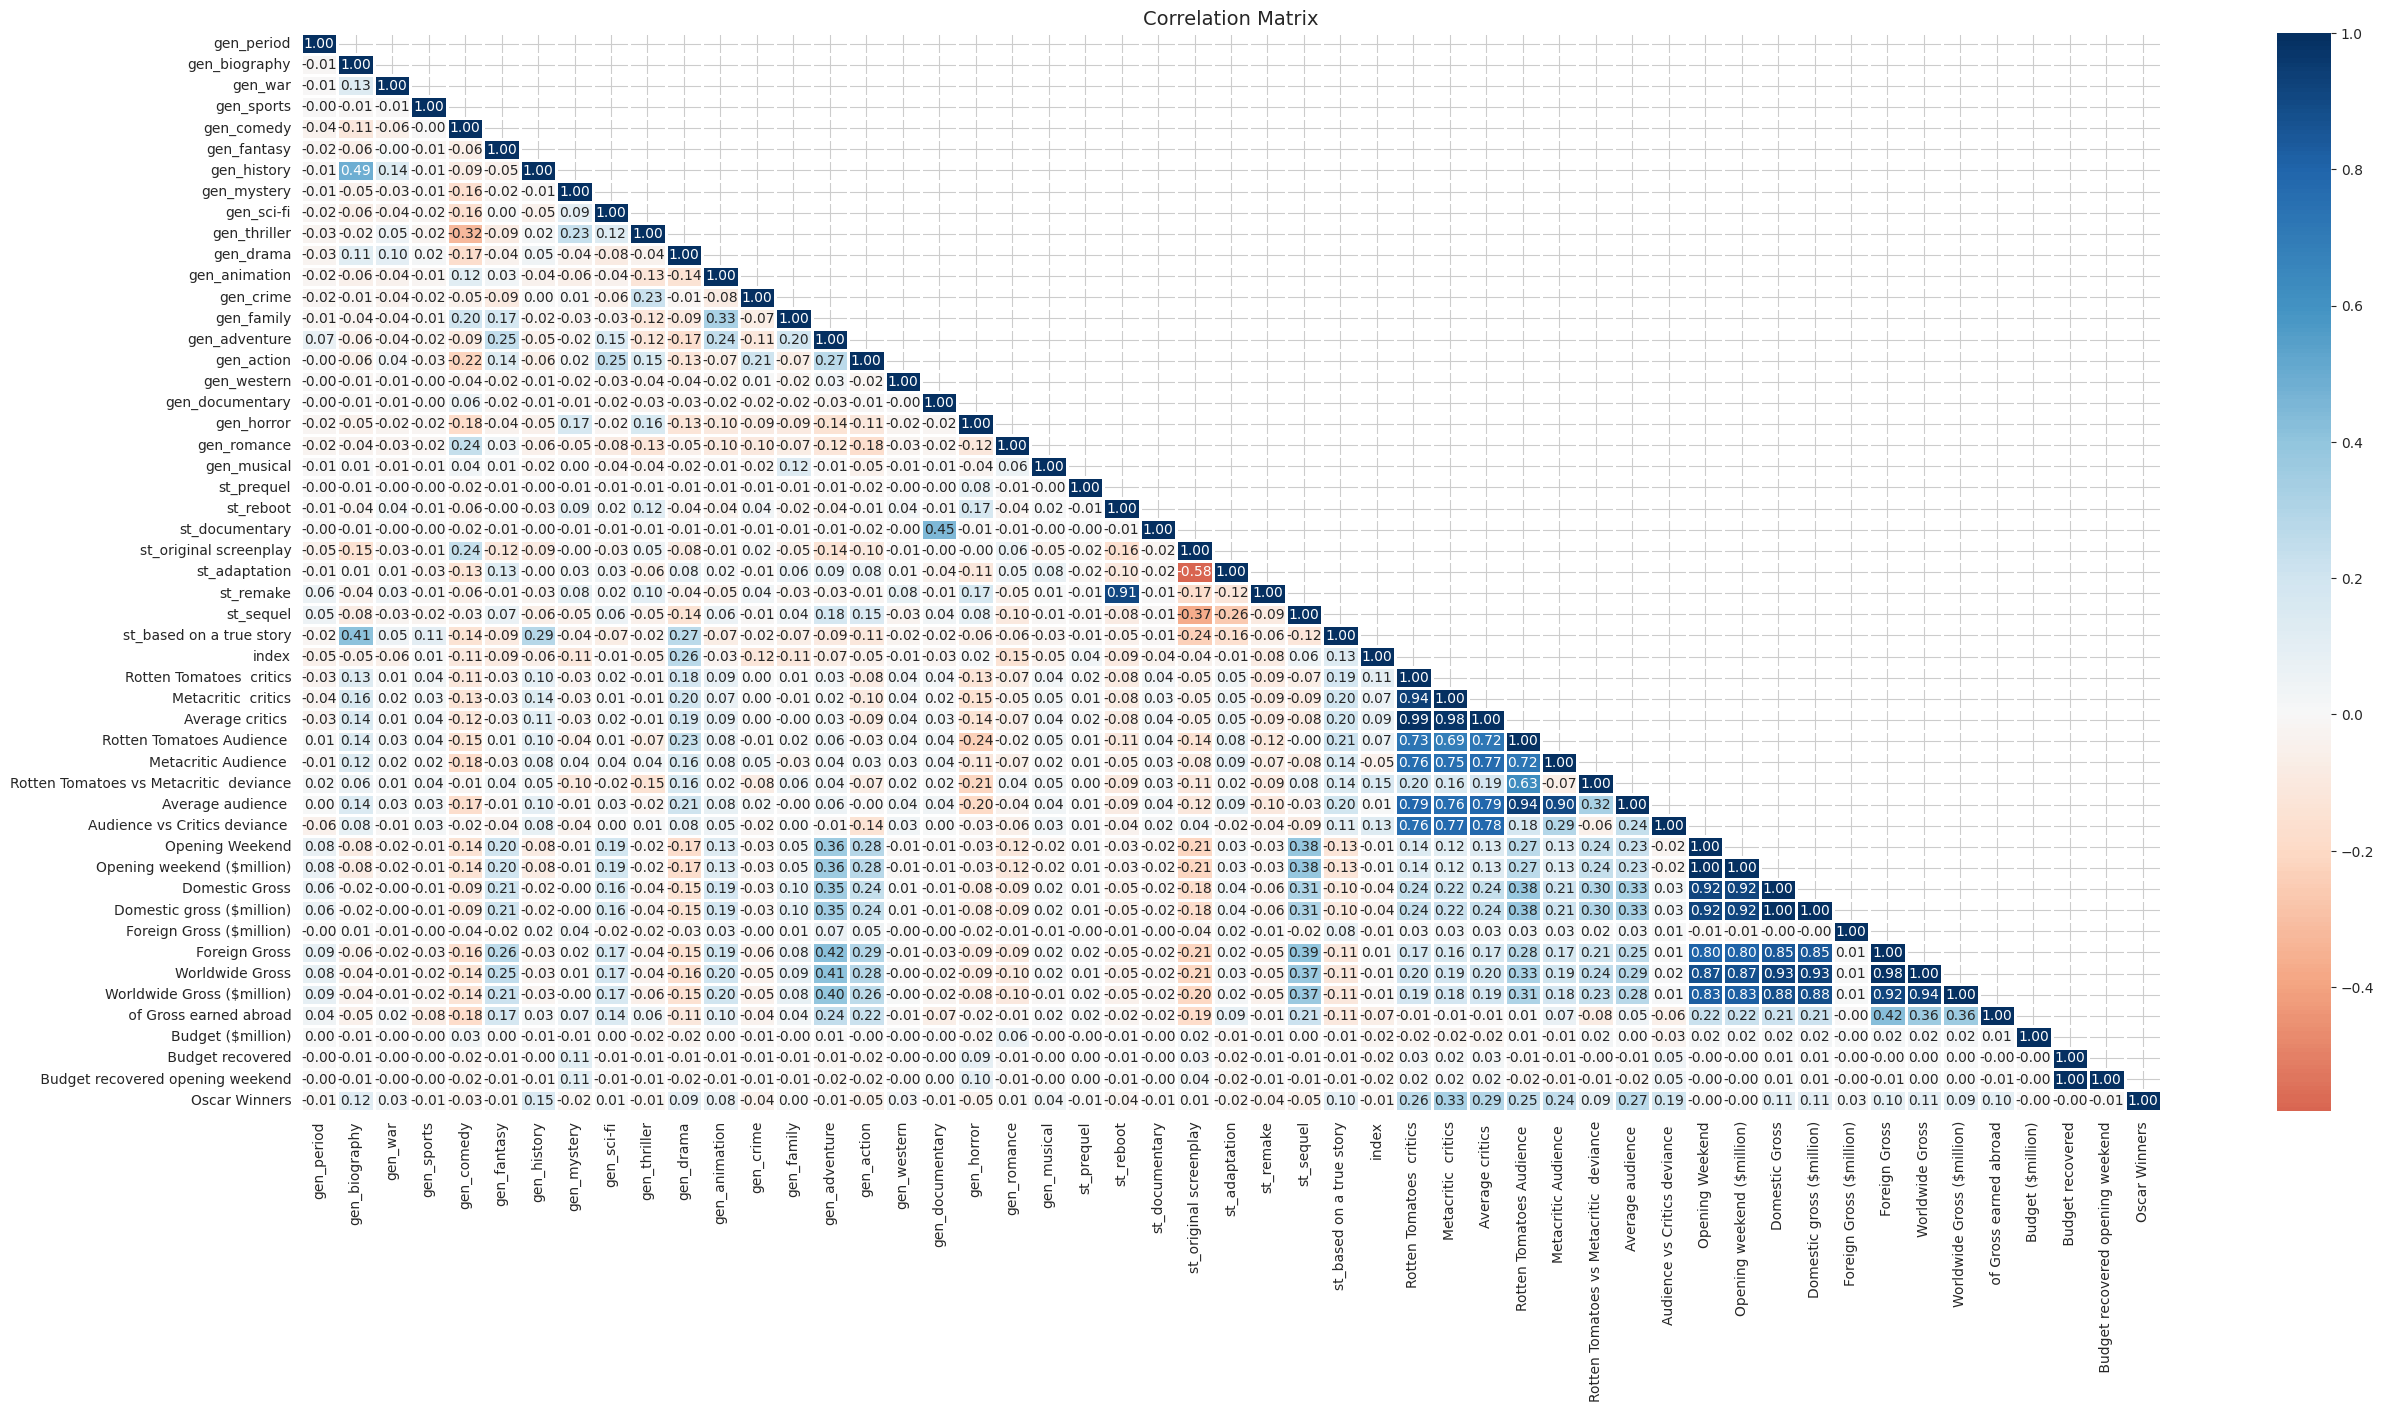

In [320]:
# Reset background style
sns.set_style('whitegrid')

corr = df_cl_corr.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(30, 14))
sns.heatmap(corr, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

#### Basic scatterplot of critics and audience scores

<Axes: xlabel='Average critics ', ylabel='Average audience '>

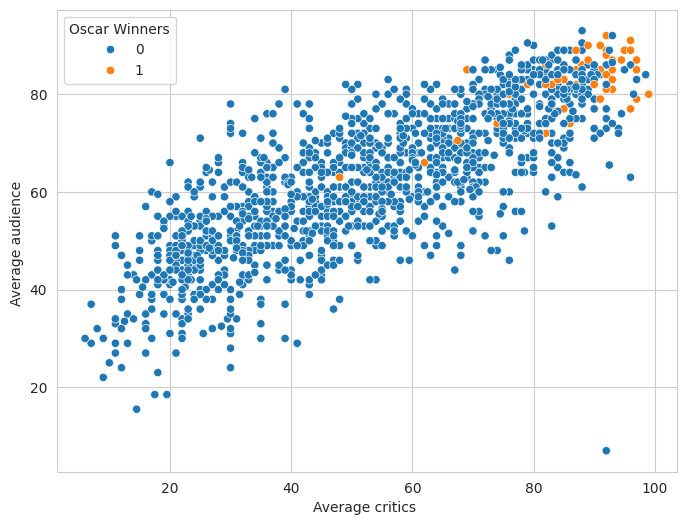

In [321]:
# simple scatterplot of average scores
plt.figure(figsize= (8,6))
sns.scatterplot(data=df_cl, x='Average critics ', y='Average audience ', hue='Oscar Winners')

### 3.3 PCA Analysis

#### Calculate most important principal components

In [322]:
x = df_cl.drop(['Oscar Winners', 'Film', 'Year', 'Release Date (US)', 'Oscar Detail', 'index', 'Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)'], axis=1).values
y = df_cl['Oscar Winners'].values
meta = df_cl['Film'].values

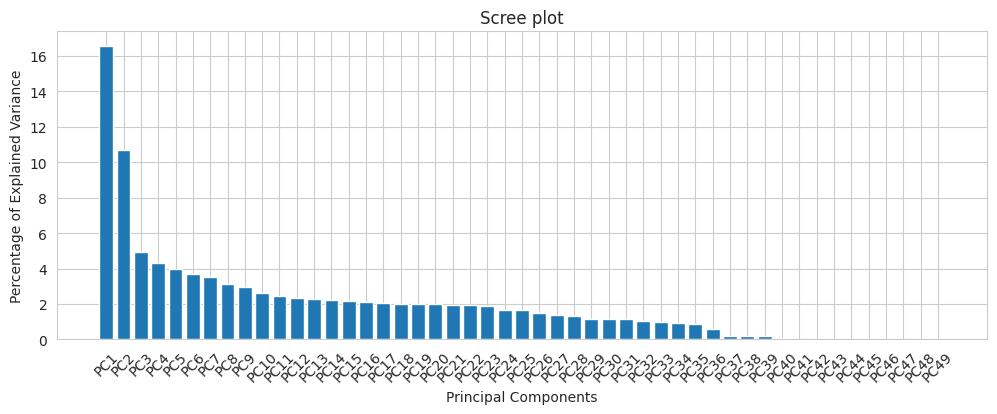

In [326]:
# Fit and scale data
x = StandardScaler().fit_transform(x)

pca = PCA()

# Fit and scale 
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df[['Oscar Winners']]], axis = 1)

plt.figure(figsize=(12,4))
plt.xticks(rotation=45)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

Text(0, 0.5, 'Cumulative explanied variance')

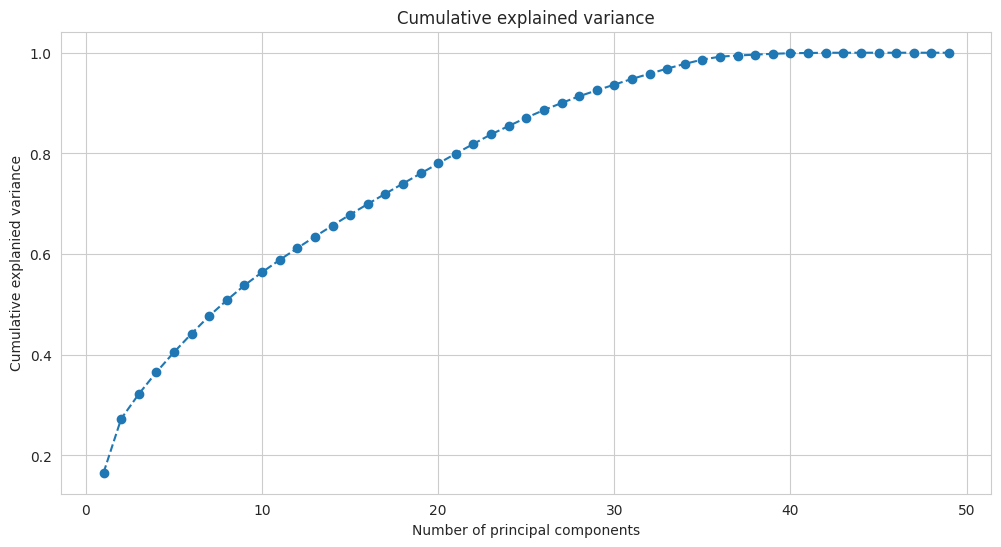

In [294]:
plt.figure(figsize= (12,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')

<Axes: xlabel='PC1 - 16.56%', ylabel='PC2 - 10.72%'>

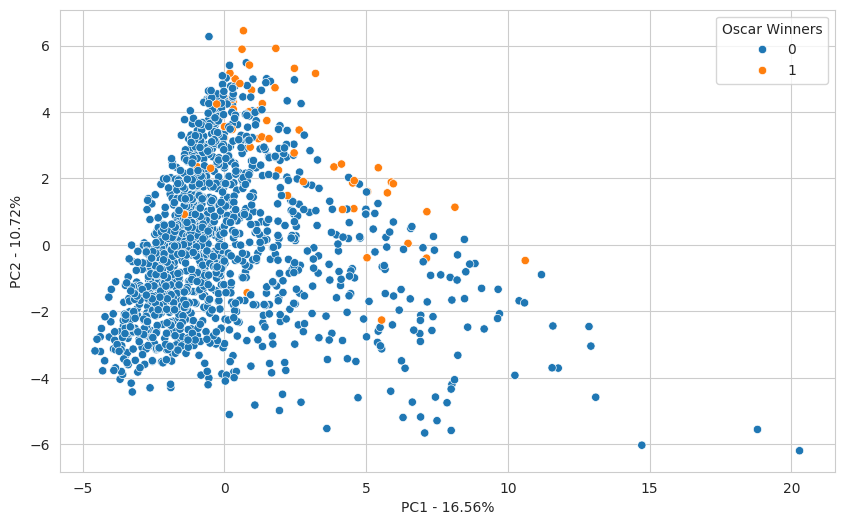

In [342]:
plt.figure(figsize=(10, 6))
plt.xlabel(f'PC1 - {per_var[0]}%')
plt.ylabel(f'PC2 - {per_var[1]}%')
sns.scatterplot(data=final_df, x="PC1", y='PC2', hue='Oscar Winners')

#### Recalculating PCA with most important principal components

In [343]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
#TODO use principal components for clustering

# 4. Prediction model

TODO:
- Use another model like 'tree'
- Run models many times and take average scores and construct AOC curves

### 4.1 Build training data

#### Balance classes

In [724]:
# remove unecessesary features from dataset
df = df.drop(['Opening Weekend', 'Domestic Gross', 'Foreign Gross', 'Worldwide Gross', 'Rotten Tomatoes vs Metacritic  deviance', 'Audience vs Critics deviance ', 'Worldwide Gross ($million)', ' of Gross earned abroad', 'Average audience ', 'Average critics ', ' Budget recovered', ' Budget recovered opening weekend'], axis=1)

In [725]:
# Select all oscar winning movies
df_oscar_winners = df[df['Oscar Winners'] == 1]

# Pick a random subset from non oscar winning movies
df_no_oscar_winners = df[df['Oscar Winners'] == 0].sample(len(df_oscar_winners) * 2)

frames = [df_oscar_winners, df_no_oscar_winners]

df_nn = pd.concat(frames)
df_nn = df_nn.sample(frac=1) # Shuffle rows

#### Prepare training and testing splits

In [567]:
# USE THIS CELL FOR SKLEARN TEST_TRAIN_SPLIT WITH STRATIFY
features = df_nn.drop(['Oscar Winners'], axis=1)
labels = df_nn['Oscar Winners']

X = torch.from_numpy(features.to_numpy(dtype='float32'))
y = torch.from_numpy(labels.to_numpy(dtype='float32')).unsqueeze(dim=1)

print(f'Shapes: X: {X.shape}, y: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Shapes: X: torch.Size([165, 37]), y: torch.Size([165, 1])


In [ ]:
# Check stratification (FOR DEBUGGING. WILL BE REMOVED LATER)
train = 0
for item in y_train:
    if item.item() == 1:
        train += 1

test = 0
for item in y_test:
    if item.item() == 1:
        test += 1

print(f'Oscar winners in training labels: {train}\nOscar winners in testing labels: {test}')

Oscar winners in training labels: 38
Oscar winners in testing labels: 17


In [568]:
# Check tensor dtypes FOR DEBUGGING
print(f'Check tensors data types:\n{X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype}')

Check tensors data types:
(torch.float32, torch.float32, torch.float32, torch.float32)


### 4.2 Define binary classification neural network with PyTorch

#### Oscar classification model class

In [569]:
class OscarClassification(nn.Module):
    def __init__(self, input_features: int, output_features: int):
        super(OscarClassification, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=10),
            nn.ReLU(),            
            nn.Linear(in_features=10, out_features=output_features)
        )
    
    # Not using sigmoid here when use BCEWithLogits loss function
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

#### Define loss, optimizer and accuracy functions and initialize model

In [570]:
# Accuracy calculator helper function
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

In [571]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'Device used: {device}')

# Initialize model
model = OscarClassification(input_features=X_train.shape[1], output_features=1).to(device)

# Loss function
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)

# Optimizer functions
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer= torch.optim.Adam(model.parameters(), lr=0.01)

Device used: cuda


### 4.3 Train and test model

In [572]:
# torch.use_deterministic_algorithms(True)
torch.manual_seed(42)

epochs = 400

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# start_time = timer()
# start_resources = psutil.cpu_times()

for epoch in tqdm(range(epochs), desc='Training...'):
    model.train()

    # Forward passs
    y_hat = model(X_train)
    loss = loss_fn(y_hat, y_train)    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate prediction accuracy
    y_train_pred = torch.round(torch.sigmoid(y_hat))
    acc = accuracy_fn(y_pred=y_train_pred, y_true=y_train)

    ### Testing
    model.eval()
    with torch.inference_mode():

        y_hat = model(X_test)

        test_loss = loss_fn(y_hat, y_test)

        y_test_pred = torch.round(torch.sigmoid(y_hat))

        test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

    if epoch % int(epochs/10) == 0 or epoch == epochs-1:
        print(f'Epoch: {epoch:04d} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# end_time = timer()
# end_resources = start_resources = psutil.cpu_times()

# print(f'Resources: {start_resources}')


# print_train_time(start=start_time, end=end_time, device=device)

Training...:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 0000 | Loss: 6.5687, Acc: 33.04% | Test Loss: 1.7310, Test Acc: 30.00%
Epoch: 0040 | Loss: 0.4090, Acc: 79.13% | Test Loss: 0.5807, Test Acc: 68.00%
Epoch: 0080 | Loss: 2.8008, Acc: 77.39% | Test Loss: 0.6034, Test Acc: 70.00%
Epoch: 0120 | Loss: 1.2281, Acc: 81.74% | Test Loss: 0.5480, Test Acc: 70.00%
Epoch: 0160 | Loss: 0.6634, Acc: 83.48% | Test Loss: 0.4891, Test Acc: 74.00%
Epoch: 0200 | Loss: 1.0494, Acc: 83.48% | Test Loss: 0.5290, Test Acc: 72.00%
Epoch: 0240 | Loss: 1.2717, Acc: 88.70% | Test Loss: 0.4527, Test Acc: 80.00%
Epoch: 0280 | Loss: 0.3188, Acc: 87.83% | Test Loss: 0.4551, Test Acc: 72.00%
Epoch: 0320 | Loss: 0.2573, Acc: 88.70% | Test Loss: 0.4568, Test Acc: 74.00%
Epoch: 0360 | Loss: 0.2398, Acc: 90.43% | Test Loss: 0.4625, Test Acc: 74.00%
Epoch: 0399 | Loss: 0.2235, Acc: 93.04% | Test Loss: 0.4708, Test Acc: 72.00%


#### Accuracy on test split

In [573]:
with torch.inference_mode():
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_test_logits = model(X_test)
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
print(f'Test total accuracy: {accuracy_fn(y_pred=y_test_pred, y_true=y_test):.2f}%')

Test total accuracy: 72.00%


#### Test correct oscar guesses

In [574]:
correct_oscar_guesses = 0
total_oscars = 0
for pred, truth in zip(y_test_logits, y_test):
    if truth == 1:
        total_oscars += 1
        if torch.round(torch.sigmoid(pred)) == 1:
            correct_oscar_guesses += 1    

print(f'Correct oscar guesses on 30% test split: {correct_oscar_guesses} out of {total_oscars}')

Correct oscar guesses on 30% test split: 10 out of 17


### Test accuracy on whole dataset

In [ ]:
#TODO: above